<a href="https://colab.research.google.com/github/AlotaibiAmira/Breast-Cancer-Classification/blob/main/ViT_DeiTBreastCancerClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

In [ ]:
%matplotlib inline

In [ ]:
import shutil
import os 
from os import listdir


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import axis
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm
import torch
from tabulate import tabulate
from sklearn import metrics

In [ ]:
pip install transformers


In [ ]:
pip install hugsvision

In [ ]:
#For dataset
from pathlib import Path
import math
from collections import Counter
from operator import itemgetter

from torchvision import transforms
from torchvision.datasets import ImageFolder

from PIL import Image, ImageEnhance
from hugsvision.dataio.VisionDataset import VisionDataset

# **Utilities**

In [ ]:
#Taken from:
#https://github.com/qanastek/HugsVision/blob/b925f370cb652c95fa1b19b4ed844b4fe922a014/hugsvision/nnet/VisionClassifierTrainer.py
def evaluate_f1_score(model,feature_extractor):

    # Get the hypothesis and predictions
    all_target, all_preds = evaluate(model,feature_extractor)

    table = metrics.classification_report(
      all_target,
      all_preds,
      labels = [int(a) for a in list(id2label.keys())],
      target_names = list(label2id.keys()),
      zero_division = 0,
      digits=4,
    )
    print(table)


    return all_target, all_preds


In [ ]:
#Taken from:
#https://github.com/qanastek/HugsVision/blob/b925f370cb652c95fa1b19b4ed844b4fe922a014/hugsvision/nnet/VisionClassifierTrainer.py
def evaluate(model,feature_extractor):
        
    all_preds  = []
    all_target = []

    # For each image
    for image, label in tqdm(test):

        # Compute
        inputs  = feature_extractor(images=image, return_tensors="pt").to(device)
        outputs = model(**inputs)

        # Get predictions from the softmax layer
        preds = outputs.logits.softmax(1).argmax(1).tolist()
        
        all_preds.extend(preds)

        all_target.append(label)

    return all_target, all_preds

# **ViT Ensemble two models**

In [ ]:
def EnsembleViT(model1,model2,feature_extractor1,feature_extractor2,data):
  
  all_preds = []
  missing = []
  
  for image, lable in tqdm(data):

    # assign input to the model and get the output of the model
    inputs1 = feature_extractor1(images=image, return_tensors="pt").to(device)
    outputs1 = model1(**inputs1)

    inputs2 = feature_extractor2(images=image, return_tensors="pt").to(device)
    outputs2 = model2(**inputs2)

    #get predect
    preds1_indx = outputs1.logits.softmax(1).argmax(1).tolist()
    preds2_indx = outputs2.logits.softmax(1).argmax(1).tolist()

    preds1 = outputs1.logits.softmax(1).tolist()[0]
    preds2 = outputs2.logits.softmax(1).tolist()[0]
    
    #comput the sot voting
    vot_combination =[(x + y)/2 for x,y in zip(preds1,preds2)]
    high_vot = np.argmax(vot_combination)

    all_preds.append(high_vot)

    if (high_vot != lable):
          missing.append([image,lable,high_vot])

  return all_preds,missing

In [ ]:
def test_acc(pred, data):

  all_target = []
  
  #get true lable
  for image, lable in tqdm(data):
    all_target.append(lable)
  
  table = metrics.classification_report(
      all_target,
      pred,
      labels = [int(a) for a in list(id2label.keys())],
      target_names = list(label2id.keys()),
      zero_division = 0,
      digits=4,
    )
  print(table)

  return table , all_target

# **Load dataset**

In [ ]:
train, test, id2label, label2id = VisionDataset.fromImageFolder(
  "the path of dataset",#past the path of the data here
  test_ratio   = 0.20,
  balanced     = True,
  augmentation = False,
)

# **Load and test the models**

In [ ]:
from transformers import ViTForImageClassification
from transformers import DeiTFeatureExtractor,DeiTForImageClassification  
from transformers import BeitFeatureExtractor, BeitForImageClassification  
from transformers import ViTFeatureExtractor


In [ ]:
#you can use your fine-tuned model here I put the model introduced by google
model1 = ViTForImageClassification.from_pretrained(
	    "google/vit-base-patch16-224",# https://huggingface.co/docs/transformers/model_doc/vit
	    
	)
feature_extractor1 = ViTFeatureExtractor.from_pretrained(
		"google/vit-base-patch16-224",
    
	)

In [ ]:
#you can use your fine-tuned model here I put the model introduced by facebook
model2 = ViTForImageClassification.from_pretrained( 
	    "facebook/deit-base-patch16-224", #https://huggingface.co/facebook/deit-base-distilled-patch16-224
	    
	)
feature_extractor2 = ViTFeatureExtractor.from_pretrained(
		"google/vit-base-patch16-224",
    
	)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
mix_pred , missing = EnsembleViT(model1,model2,feature_extractor1,feature_extractor2,test)

100%|██████████| 711/711 [19:03<00:00,  1.61s/it]


In [ ]:
table, true_classes = test_acc(mix_pred, test)


100%|██████████| 711/711 [00:11<00:00, 61.05it/s]

              precision    recall  f1-score   support

           A     1.0000    1.0000    1.0000       104
          DC     1.0000    0.9663    0.9829        89
           F     0.9775    0.9667    0.9721        90
          LC     0.9479    0.9891    0.9681        92
          MC     1.0000    0.9884    0.9942        86
          PC     0.9794    1.0000    0.9896        95
          PT     0.9494    0.9494    0.9494        79
          TA     1.0000    0.9868    0.9934        76

    accuracy                         0.9817       711
   macro avg     0.9818    0.9808    0.9812       711
weighted avg     0.9820    0.9817    0.9818       711



# **Test each model seprately**

In [ ]:
target1, predect1 = evaluate_f1_score(model1 , feature_extractor1)

100%|██████████| 711/711 [09:07<00:00,  1.30it/s]

              precision    recall  f1-score   support

           A     0.9811    1.0000    0.9905       104
          DC     1.0000    0.9663    0.9829        89
           F     0.9655    0.9333    0.9492        90
          LC     0.9479    0.9891    0.9681        92
          MC     1.0000    0.9884    0.9942        86
          PC     0.9794    1.0000    0.9896        95
          PT     0.9487    0.9367    0.9427        79
          TA     1.0000    1.0000    1.0000        76

    accuracy                         0.9775       711
   macro avg     0.9778    0.9767    0.9771       711
weighted avg     0.9777    0.9775    0.9774       711



In [ ]:
target2, predect2 = evaluate_f1_score(model2 , feature_extractor2)

100%|██████████| 711/711 [09:13<00:00,  1.29it/s]

              precision    recall  f1-score   support

           A     0.9904    0.9904    0.9904       104
          DC     1.0000    0.9551    0.9770        89
           F     0.9667    0.9667    0.9667        90
          LC     0.9474    0.9783    0.9626        92
          MC     0.9882    0.9767    0.9825        86
          PC     0.9691    0.9895    0.9792        95
          PT     0.9494    0.9494    0.9494        79
          TA     0.9868    0.9868    0.9868        76

    accuracy                         0.9747       711
   macro avg     0.9747    0.9741    0.9743       711
weighted avg     0.9750    0.9747    0.9747       711



# **confusion_matrix**

In [ ]:
predicted_classes =np.array(mix_pred)

In [ ]:
true_classes = np.array(true_classes)

In [ ]:
categories = []
for i in id2label:
  categories.append(id2label[i])

[Text(69.0, 0.5, 'True Label'), Text(0.5, 69.0, 'Predicted Label')]

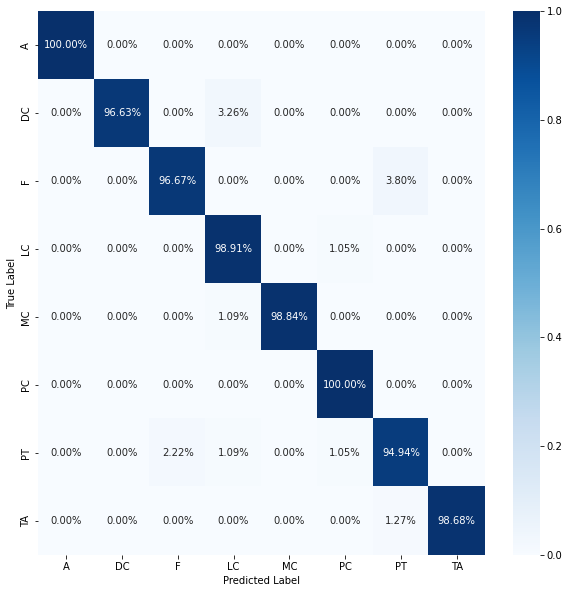

In [ ]:
%matplotlib inline
from matplotlib.ticker import FuncFormatter
confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (10, 10))
plt.xlabel('Predicted Label ')
plt.ylabel('True Label ')
fmt = lambda x,pos: '{:.0%}'.format(x)
ax = sns.heatmap(confusionmatrix/np.sum(confusionmatrix,axis=1) ,cmap = 'Blues',annot = True, cbar = True, fmt='.2%',
            xticklabels=categories,yticklabels=categories)

ax.set(ylabel='True Label',xlabel='Predicted Label')

# **Plot missclassified images**

In [ ]:
def plot_img(missing):
  i=1
  plt.figure(figsize=(10,10))
  for img,label,pred in missing:
    plt.subplot(4,4,i)
    i=i+1
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    label = str(label)
    pred = str(pred)
    plt.title('True Label = %s'%id2label[label],fontsize=12)
    plt.xlabel('Predicted Label = %s'%id2label[pred],fontsize=12)

 


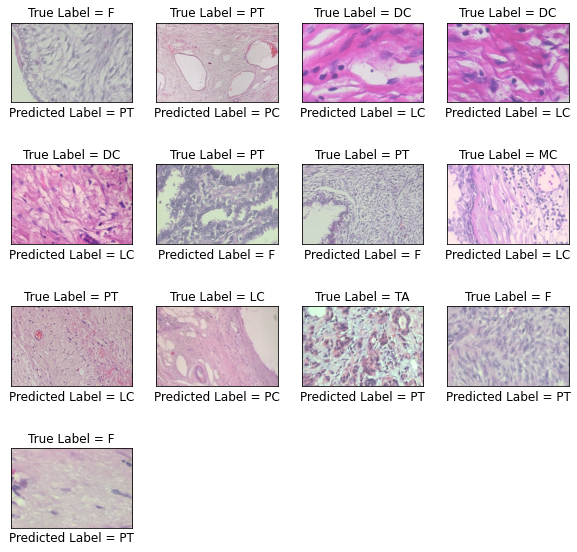

In [ ]:
plot_img(missing)

# **ROC curve**

In [ ]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

In [ ]:
n_class = 8
fpr = dict()
tpr = dict()

roc_auc = dict()

for i in range(n_class):
  fpr[i] , tpr[i], _ = roc_curve(true_classes[:]==i,predicted_classes[:]==i)
  roc_auc[i] = auc(fpr[i] , tpr[i])


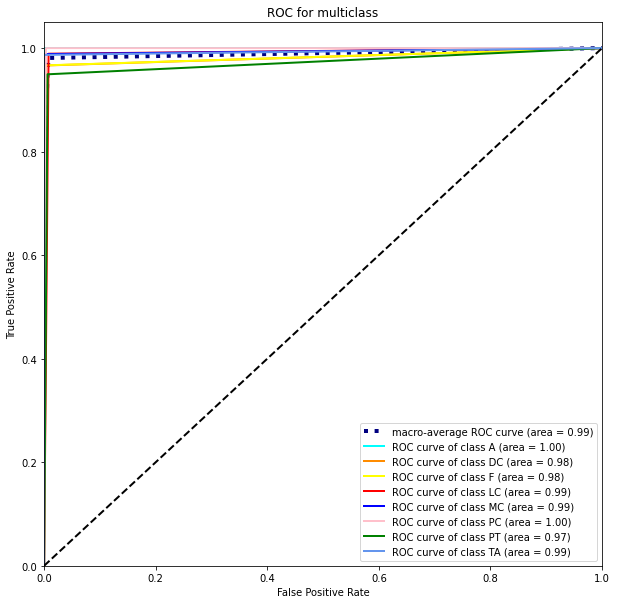

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_class)]))
lw = 2
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_class):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_class

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize = (10, 10))

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "yellow","Red","blue","pink","green","cornflowerblue"])
for i, color in zip(range(n_class), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(id2label[str(i)], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for multiclass")
plt.legend(loc="lower right")
plt.show()

# **AUC**

In [ ]:
roc_auc["macro"]

0.9891122812288239